# Geodesic Plots

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

from abc import ABC

import matplotlib.pyplot as plt

from geodesics import GradientDescent, JAXOptimization, ScipyOptimization, GC_LineSearch
from manifolds import nSphere, nEuclidean, nParaboloid, HyperbolicParaboloid

2024-05-31 09:31:58.978279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyper-Parameters

In [2]:
tol = 1e-4
max_iter = 1000
T = 100
line_search_iter = 100

### Gradient Descent

In [3]:
grad_decay = 0.90
grad_lr_rate = 1.0

### JAX Optimization

In [4]:
jax_lr_rate = 0.01

### Geodesic Control

In [5]:
gc_decay = 0.99
gc_lr_rate = 1.0

## Geodesic Computations on $\mathbb{R}^{2}$

### Plotting

In [6]:
M = nEuclidean(dim=2)

In [7]:
z0 = jnp.array([-1.0,-1.0])
zT = jnp.array([1.0,1.0])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Ground Truth

In [8]:
xt_true = M.Geodesic(z0,zT)
true_dist = M.dist(z0,zT)

### Gradient Descent

In [9]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [10]:
xt_init = Geodesic.init_fun(z0,zT,T)
init_length = M.length(xt_init)

In [11]:
xt_grad, grad, grad_idx = Geodesic(z0,zT)
grad_length = M.length(xt_grad)

### JAX Optimization

In [12]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [13]:
xt_jax, grad, jax_idx = Geodesic(z0,zT)
jax_length = M.length(xt_jax)

### Scipy Optimization

In [14]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [15]:
xt_scipy, grad, scipy_idx = Geodesic(z0,zT)
scipy_length = M.length(xt_scipy)

### Geodesic Control

In [16]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=gc_decay,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [17]:
xt_gc, grad, gc_idx = Geodesic(z0,zT)
gc_length = M.length(xt_gc)

### Plotting

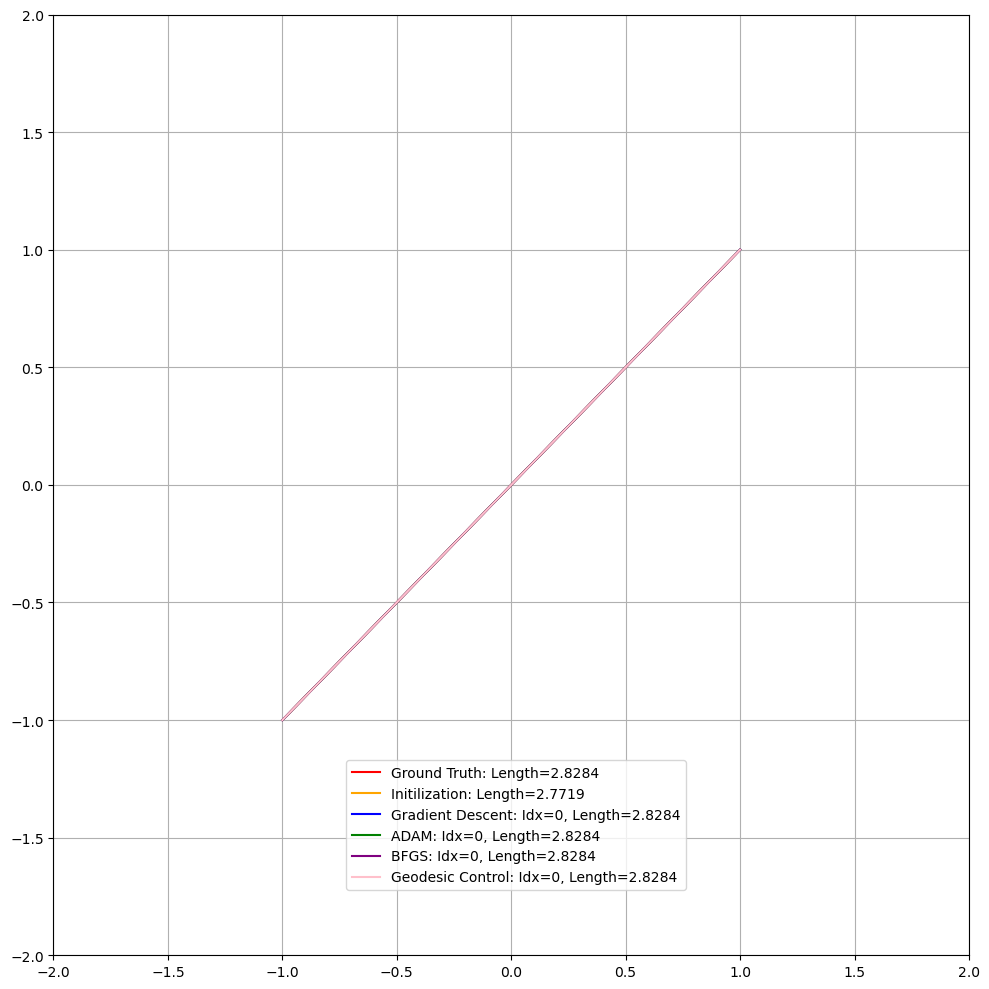

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(xt_true[:,0], xt_true[:,1], color='red', alpha=1.0,
       label=f"Ground Truth: Length={true_dist:.4f}")
ax.plot(xt_init[:,0], xt_init[:,1], color='orange', alpha=1.0,
        label=f"Initilization: Length={init_length:.4f}")
ax.plot(xt_grad[:,0], xt_grad[:,1], color='blue', alpha=1.0,
        label=f"Gradient Descent: Idx={grad_idx}, Length={grad_length:.4f}")
ax.plot(xt_jax[:,0], xt_jax[:,1], color='green', alpha=1.0,
        label=f"ADAM: Idx={jax_idx}, Length={jax_length:.4f}")
ax.plot(xt_scipy[:,0], xt_scipy[:,1], color='purple', alpha=1.0,
        label=f"BFGS: Idx={scipy_idx}, Length={scipy_length:.4f}")
ax.plot(xt_gc[:,0], xt_gc[:,1], color='pink', alpha=1.0,
        label=f"Geodesic Control: Idx={gc_idx}, Length={gc_length:.4f}")
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.grid(True)
#ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.1), ncol=1)

plt.show()


## Geodesic Computations on $\mathbb{S}^{2}$

### Plotting

In [19]:
M = nSphere(dim=2)

In [20]:
x0 = jnp.array([jnp.cos(5*jnp.pi/4),jnp.sin(5*jnp.pi/4),0.8])
xT = jnp.array([jnp.cos(0.0),jnp.sin(0.0),0.8])

x0 /= jnp.linalg.norm(x0)
xT /= jnp.linalg.norm(xT)

z0 = M.invF(x0)
zT = M.invF(xT)

In [21]:
class SpherePlot(ABC):
    def __init__(self, seed=2712):
        
        self.seed = 2712
        self.rng_key = jrandom.PRNGKey(seed)

    def sphere_grid(self, n_points:int=100):
        self.rng_key, subkey = jrandom.split(self.rng_key)
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return x1,x2,x3
         

In [22]:
plot_sphere = SpherePlot()

### Ground Truth

In [23]:
xt_true = M.Geodesic(x0,xT)
true_dist = M.dist(x0,xT)

### Gradient Descent

In [24]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [25]:
zt = Geodesic.init_fun(z0,zT,T)
xt_init = jnp.vstack((x0, vmap(lambda z: M.F(z))(zt), xT))
init_length = M.length(xt_init)

In [26]:
zt, grad, grad_idx = Geodesic(z0,zT)

In [27]:
xt_grad = vmap(lambda z: M.F(z))(zt)
grad_length = M.length(xt_grad)

In [28]:
jnp.linalg.norm(grad.reshape(-1))

Array(0.01912309, dtype=float32)

### JAX Optimization

In [29]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [30]:
zt, grad, jax_idx = Geodesic(z0,zT)

In [31]:
xt_jax = vmap(lambda z: M.F(z))(zt)
jax_length = M.length(xt_jax)

In [32]:
jnp.linalg.norm(grad)

Array(0.00672299, dtype=float32)

### Scipy Optimization

In [33]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [34]:
zt, grad, scipy_idx = Geodesic(z0,zT)

In [35]:
xt_scipy = vmap(lambda z: M.F(z))(zt)
scipy_length = M.length(xt_scipy)

In [36]:
jnp.linalg.norm(grad.reshape(-1))

Array(7.474845e-05, dtype=float32)

### Geodesic Control

In [37]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=gc_decay,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [38]:
zt, grad, gc_idx = Geodesic(z0,zT)

In [39]:
xt_gc = vmap(lambda z: M.F(z))(zt)
gc_length = M.length(xt_gc)

In [40]:
jnp.linalg.norm(grad.reshape(-1))

Array(4.3807573e-05, dtype=float32)

### Plotting

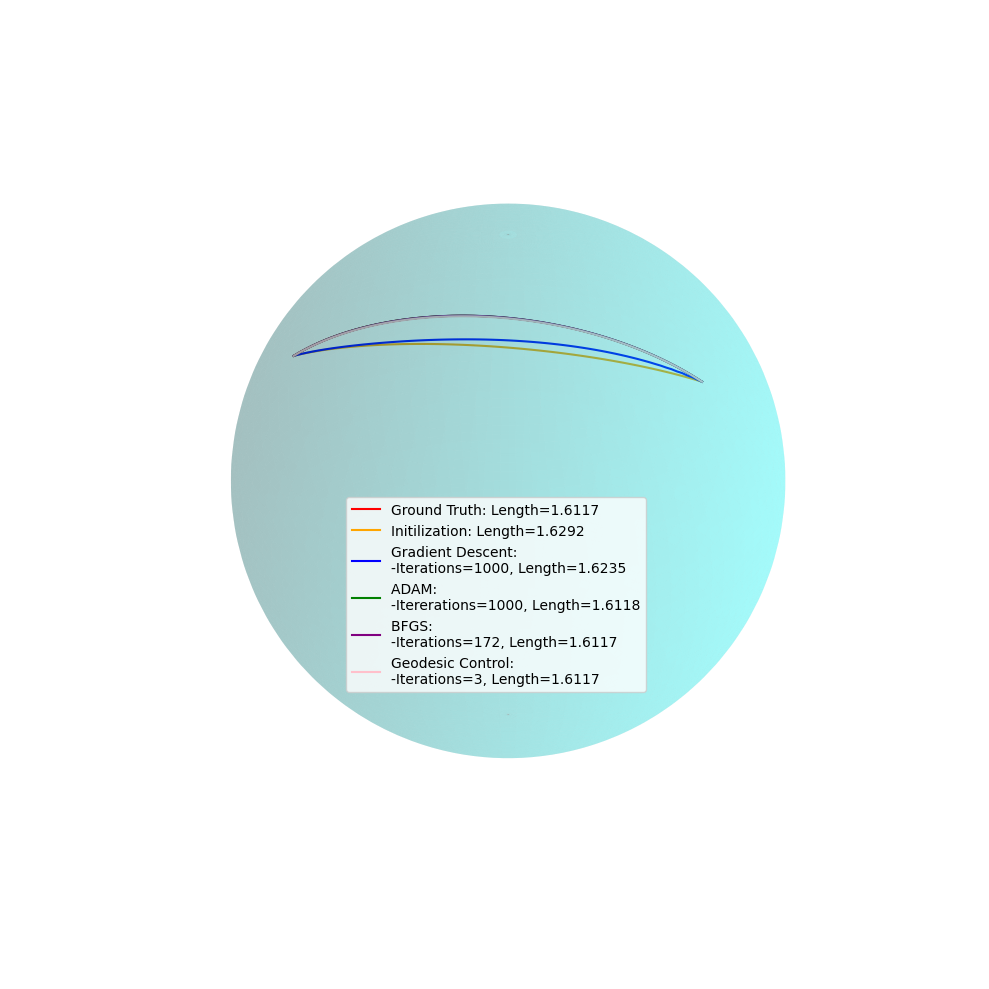

In [41]:
x1,x2,x3 = plot_sphere.sphere_grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(xt_true[:,0], xt_true[:,1], xt_true[:,2], color='red', alpha=1.0,
       label=f"Ground Truth: Length={true_dist:.4f}")
ax.plot(xt_init[:,0], xt_init[:,1], xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={init_length:.4f}")
ax.plot(xt_grad[:,0], xt_grad[:,1], xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={grad_idx}, Length={grad_length:.4f}")
ax.plot(xt_jax[:,0], xt_jax[:,1], xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Itererations={jax_idx}, Length={jax_length:.4f}")
ax.plot(xt_scipy[:,0], xt_scipy[:,1], xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={scipy_idx}, Length={scipy_length:.4f}")
ax.plot(xt_gc[:,0], xt_gc[:,1], xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={gc_idx}, Length={gc_length:.4f}")
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.3), ncol=1)

plt.show()


## Geodesic Computations on Paraboloid

### Plotting

In [42]:
M = nParaboloid(dim=2)

In [43]:
r = 1.0
z0 = r*jnp.array([jnp.cos(-5*jnp.pi/4), jnp.sin(-5*jnp.pi/4)])
zT = r*jnp.array([jnp.cos(0.0),jnp.sin(0.0)])

x0 = M.F(z0)
xT = M.F(zT)

In [44]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2
         

In [45]:
plot_paraboloid = ParaboloidPlot()

### Gradient Descent

In [46]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [47]:
zt = Geodesic.init_fun(z0,zT,T)
xt_init = jnp.vstack((x0, vmap(lambda z: M.F(z))(zt), xT))
init_length = M.length(xt_init)

In [48]:
zt, grad, grad_idx = Geodesic(z0,zT)

In [49]:
xt_grad = vmap(lambda z: M.F(z))(zt)
grad_length = M.length(xt_grad)

### JAX Optimization

In [50]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [51]:
zt, grad, jax_idx = Geodesic(z0,zT)

In [52]:
xt_jax = vmap(lambda z: M.F(z))(zt)
jax_length = M.length(xt_jax)

### Scipy Optimization

In [53]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [54]:
zt, grad, scipy_idx = Geodesic(z0,zT)

In [55]:
xt_scipy = vmap(lambda z: M.F(z))(zt)
scipy_length = M.length(xt_scipy)

### Geodesic Control

In [56]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=gc_decay,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [57]:
zt, grad, gc_idx = Geodesic(z0,zT)

In [58]:
xt_gc = vmap(lambda z: M.F(z))(zt)
gc_length = M.length(xt_gc)

### Plotting

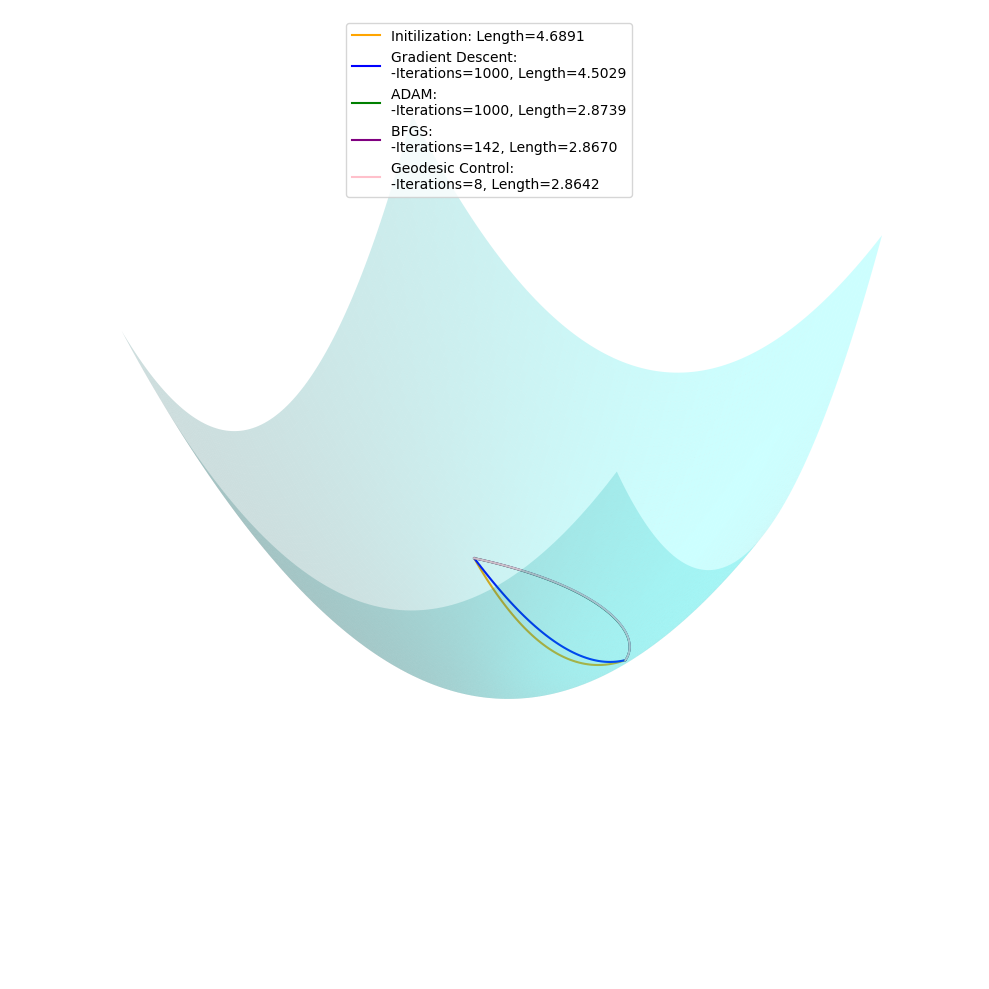

In [59]:
x1,x2,x3 = ParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(xt_init[:,0], xt_init[:,1], xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={init_length:.4f}")
ax.plot(xt_grad[:,0], xt_grad[:,1], xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={grad_idx}, Length={grad_length:.4f}")
ax.plot(xt_jax[:,0], xt_jax[:,1], xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={jax_idx}, Length={jax_length:.4f}")
ax.plot(xt_scipy[:,0], xt_scipy[:,1], xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={scipy_idx}, Length={scipy_length:.4f}")
ax.plot(xt_gc[:,0], xt_gc[:,1], xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={gc_idx}, Length={gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()


## Geodesic Computations on Hyperbolic Paraboloid

### Plotting

In [60]:
M = HyperbolicParaboloid()

In [61]:
r = 1.0
z0 = r*jnp.array([-3.,-3.])
zT = r*jnp.array([3.,-3.])

x0 = M.F(z0)
xT = M.F(zT)

In [62]:
class HyperbolicParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-5.0, 5.0, n_points)
        x2 = jnp.linspace(-5.0, 5.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2-X2**2
         

In [63]:
plot_hyperbolicparaboloid = HyperbolicParaboloidPlot()

### Gradient Descent

In [64]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [65]:
zt = Geodesic.init_fun(z0,zT,T)
xt_init = jnp.vstack((x0, vmap(lambda z: M.F(z))(zt), xT))
init_length = M.length(xt_init)

In [66]:
zt, grad, grad_idx = Geodesic(z0,zT)

In [67]:
xt_grad = vmap(lambda z: M.F(z))(zt)
grad_length = M.length(xt_grad)

### JAX Optimization

In [68]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [69]:
zt, grad, jax_idx = Geodesic(z0,zT)

In [70]:
xt_jax = vmap(lambda z: M.F(z))(zt)
jax_length = M.length(xt_jax)

### Scipy Optimization

In [71]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [72]:
zt, grad, scipy_idx = Geodesic(z0,zT)

In [73]:
xt_scipy = vmap(lambda z: M.F(z))(zt)
scipy_length = M.length(xt_scipy)

### Geodesic Control

In [74]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.98,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [75]:
zt, grad, gc_idx = Geodesic(z0,zT)

In [76]:
xt_gc = vmap(lambda z: M.F(z))(zt)
gc_length = M.length(xt_gc)

### Plotting

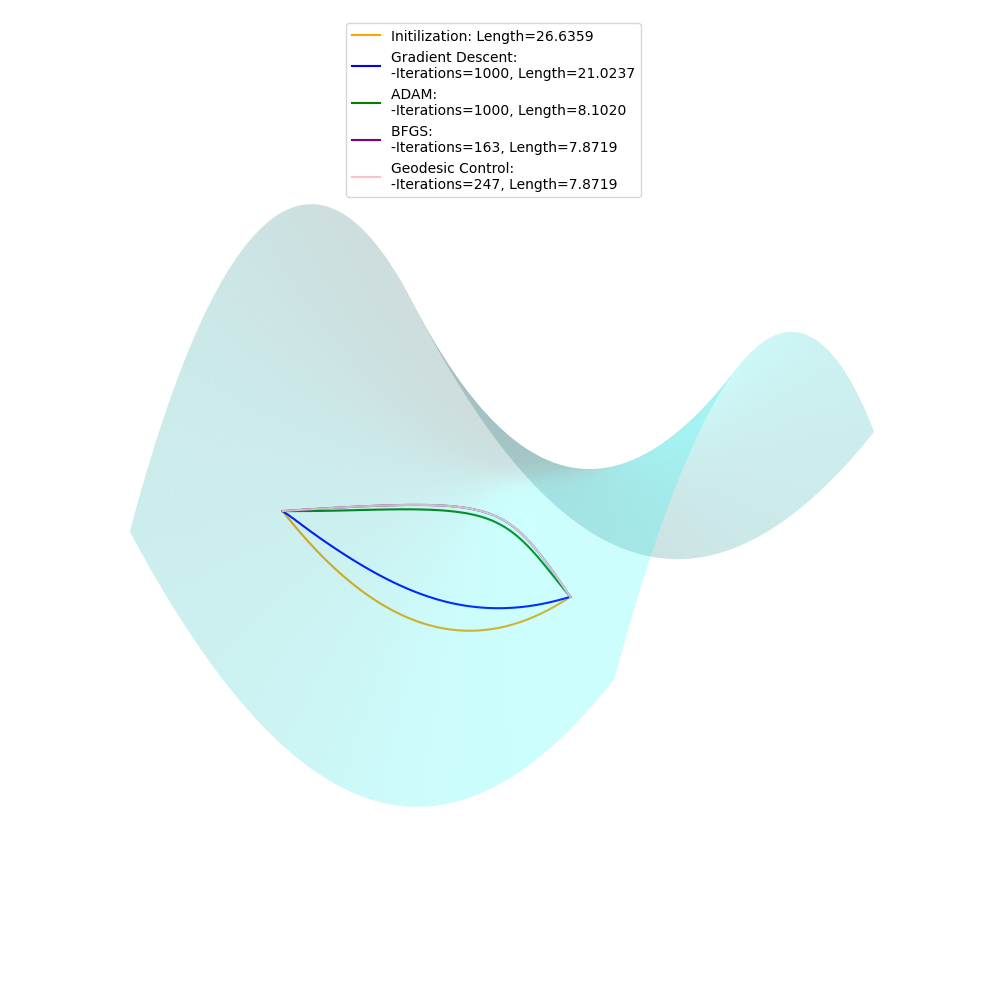

In [77]:
x1,x2,x3 = HyperbolicParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(xt_init[:,0], xt_init[:,1], xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={init_length:.4f}")
ax.plot(xt_grad[:,0], xt_grad[:,1], xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={grad_idx}, Length={grad_length:.4f}")
ax.plot(xt_jax[:,0], xt_jax[:,1], xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={jax_idx}, Length={jax_length:.4f}")
ax.plot(xt_scipy[:,0], xt_scipy[:,1], xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={scipy_idx}, Length={scipy_length:.4f}")
ax.plot(xt_gc[:,0], xt_gc[:,1], xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={gc_idx}, Length={gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()
